# Описание задания

В рамках данного задания, студент должен создать и оценить 4 типа рекомендательных систем:
* Non-personalized RS

Каждая рекомендательная система - отдельное подзадание. Подзадание считается выполненным, если студент создал рекомендательную систему, которая **лучше (или хуже, но не более чем на 10%)** системы, созданной автором данного блокнота. Системы оцениваются с использованием метрики ``HR@N``, описанной ниже.

# Детальное описание

#### Данные: 
Датасет представлен множеством отзывов к компьютерным играм (объектам) от пользователей Amazon. Каждый отзыв представлен в виде JSON-структуры со следующими полями:
* идентификатор пользователя - reviewerID
* идентификатор объекта - asin
* текст отзыва - reviewText
* рейтинг - overall
* время публикации обзора - unixReviewTime
* другие поля, не использованные автором этого блокнота (смотри полное описание JSON [тут](http://jmcauley.ucsd.edu/data/amazon/))

У каждого объекта есть как минимум 5 отзывов, каждый пользователь написал как минимум 5 отзывов. 
#### Цель: 
Построить рекомендательную систему, предсказывающую объекты, которые пользователь приобретет в ближайшем будущем. Для упрощения мы считаем, что пользователь приобрел объект, если он написал про него отзыв.
#### Подготовка данных:
Данные разделены на тренировочную и тестовую выборки по времени публикации отзывов. Первые 80% данных (более старые) используются как тренировочная выборка, остальные - как тестовая. 

Построение рекомендательной системы (т.е., выбор и тренировка моделей, оптимизация параметров и т.д.) осуществляется **только** с использованием тренировочной выборки. Все параметры, использованные в моделях, **должны быть** получены или объяснены с помощью тренировочных данных. Студент вправе использовать тренировочную выборку как его душе угодно. 

Тестирующая выборка используется **только** для оценки рекомендательной системы.

Для построения рекомендательных моделей также можно использовать JSON-поля из датасета, неиспользованные автором этого блокнота.
#### Оценка качества рекомендательной системы
Цель рекомендательной системы - посоветовать пользователю объекты, которые он захочет приобрести. Для оценки качества такой системы мы воспользуемся метрикой `hit-ratio (HR)`. 

$$
HR = \frac{1}{|U_T|}\sum_{u \in U_T} \mathrm{I}(Rel_u \cap Rec_u)
$$

* $U_T$ - множество пользователей из тестовой выборки
* $Rec_u$ - множество объектов, рекомендованных пользователю $u$ 
* $Rel_u$ - множество объектов, оцененных пользователем $u$ в тестовой выборке
* $\mathrm{I}(Rel_u \cap Rec_u)$ - бинарная функция-индикатор. Функция возвращает 1 если $Rel_u \cap Rec_u \ne \emptyset$, иначе 0

$HR=1$ если для каждого пользователя мы рекомендовали хотя бы один релевантный объект. Так как обычно пользователи просматривают только первые $N$ рекомендаций, мы будем считать метрику $HR@N$, где $N=10$ (т.е. множество $Rec_u$ будет содержать только 10 объектов). 

# Условные обозначения
* `uid` - идентификатор пользователя
* `iid` - идентификатор объекта

# Games RSs

In [2]:
# импорты, которые точно понадобятся
import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Данные взяты отсюда - http://jmcauley.ucsd.edu/data/amazon/
# http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
JSON_DATA_PATH = "data/Video_Games_5.json"
N = 10

## Анализ данных

In [5]:
import json

def iter_json_data(path):
    with open(path) as f:
        for line in f:
            data = json.loads(line)
            yield data
            
def get_data_frame():
    uid_to_id = {}
    iid_to_id = {}
    
    cols = ["uid", "iid", "review", "rating", "dt"]
    rows = []
    for d in iter_json_data(JSON_DATA_PATH):
        uid = uid_to_id.setdefault(d["reviewerID"], len(uid_to_id))
        iid = iid_to_id.setdefault(d["asin"], len(iid_to_id))
        review = d["reviewText"]
        rating = float(d["overall"])
        dt = int(d["unixReviewTime"])
        rows.append((uid, iid, review, rating, dt))
        
    return pd.DataFrame(rows, columns=cols)

In [6]:
df = get_data_frame()
df.head()

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
2,2,0,1st shipment received a book instead of the ga...,1.0,1403913600
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600


In [7]:
print("min-max количество объектов на пользователя:", 
      df.groupby("uid").iid.nunique().min(), df.groupby("uid").iid.nunique().max())
print("min-max количество пользователей на объект:", 
      df.groupby("iid").uid.nunique().min(), df.groupby("iid").uid.nunique().max())

min-max количество объектов на пользователя: 5 773
min-max количество пользователей на объект: 5 802


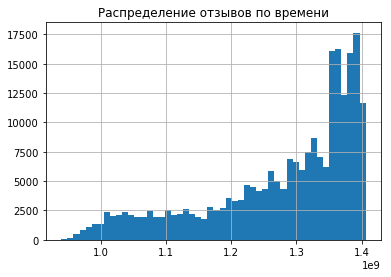

In [8]:
plt.title("Распределение отзывов по времени")
df.dt.hist(bins=50)

In [8]:
# проверяем, есть ли случаи, когда один и тот же пользователь оставляет отзывы на один и тот же объект
df.groupby(["uid", "iid"]).review.count().unique()  # ура, таких случаев нет

array([1], dtype=int64)

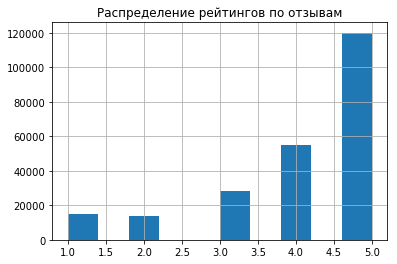

In [9]:
plt.title("Распределение рейтингов по отзывам")
df.rating.hist()

In [10]:
print("Количество объектов:", df.iid.unique().size)
print("Количество пользователей:", df.uid.unique().size)

Количество объектов: 10672
Количество пользователей: 24303


## Готовим выборки

In [11]:
def split_df_by_dt(df, p=0.8):
    """Функция разбивает df на тестовую и тренировочную выборки по времени 
    публикации отзывов (значение времени в поле dt)
    
    :param p: персентиль значений dt, которые образуют тренировочную выборку. Например p=0.8 означает, что в 
    тренировочной части будут отзывы, соответствующие первым 80% временного интервала 
    :return: два pd.DataFrame объекта
    """
    border_dt = df.dt.quantile(p)
    print("Min=%s, border=%s, max=%s" % (df.dt.min(), border_dt, df.dt.max()))
    training_df, test_df  = df[df.dt <= border_dt], df[df.dt > border_dt]
    print("Размер до очистки:", training_df.shape, test_df.shape)
    # удаляем из тестовых данных строки, соответствующие пользователям или объектам, 
    # которых нет в тренировочных данных 
    # (пользователи - избегаем проблем для персональных систем, объекты - для всех)
    test_df = test_df[test_df.uid.isin(training_df.uid) & test_df.iid.isin(training_df.iid)]
    print("Размер после очистки:", training_df.shape, test_df.shape)
    return training_df, test_df

In [12]:
training_df, test_df = split_df_by_dt(df)
del df

Min=939859200, border=1377129600.0, max=1405987200
Размер до очистки: (185427, 5) (46353, 5)
Размер после очистки: (185427, 5) (19174, 5)


In [13]:
def clean_df(df, min_review_per_uid, min_review_per_iid):
    """Функция удаляет из df строки, соответствующие пользователям и объектам, 
    у которых меньше min_review_per_uid и min_review_per_iid отзывов соответственно
    """
    _df = df.copy()
    while True:
        review_per_uid = _df.groupby("uid").review.count()
        bad_uids = review_per_uid[review_per_uid < min_review_per_uid].index
    
        review_per_iid = _df.groupby("iid").review.count()
        bad_iids = review_per_iid[review_per_iid < min_review_per_iid].index
        
        if bad_uids.shape[0] > 0 or bad_iids.shape[0] > 0:
            _df = _df[(~_df.uid.isin(bad_uids)) & (~_df.iid.isin(bad_iids))]
        else:
            break
    return _df

 ## Метрика

Для упрощения тестирования предлагается использовать словарь следующего типа:

```python
recs = {
    uid_1: {
        iid_1: score_11,
        iid_2: score_12,
        ...
    },
    uid_2: {
        iid_1: score_21,
        iid_2: score_22,
        ...
    },
    ...
}
```

где `uid_i` - идентификатор тестового пользователя, `iid_j` - идентификатор рекомендованного объекта, а `score_ij` - предсказанный рейтинг/вес объекта `j` для пользователя `i`.

In [21]:
def hit_ratio(recs_dict, test_dict):
    """Функция считает метрику hit-ration для двух словарей
    :recs_dict: словарь рекомендаций типа {uid: {iid: score, ...}, ...}
    :test_dict: тестовый словарь типа {uid: {iid: score, ...}, ...}
    """
    hits = 0
    for uid in test_dict:
        if set(test_dict[uid].keys()).intersection(recs_dict.get(uid, {})):
            hits += 1
    return hits / len(test_dict)

In [22]:
def get_test_dict(test_df):
    """Функция, конвертирующая тестовый df в словарь
    """
    test_dict = {}
    for t in test_df.itertuples():
        test_dict.setdefault(t.uid, {})
        test_dict[t.uid][t.iid] = t.rating
    return test_dict

test_dict = get_test_dict(test_df)

## Non-personalized RS

В первом подзадании студент должен построить неперсонализированную рекомендательную систему. Т.е. рекомендации для одного пользователя строятся на основе отзывов, оставленных всеми пользователями.

Ниже приведены базовые классы для рекомендателей, которые можно использовать при построении собственных моделей.

In [23]:
class BasicRecommender(object):
    def __init__(self):
        pass
    
    def get_recs(self, uid, top):
        """Строит рекомендации для пользователя uid
        :return: словарь типа {iid: score, ...}
        """
        return {}
    
    def get_batch_recs(self, uids, top):
        """Строит рекомендации для нескольких пользователей uids
        :return: словарь типа {uid: {iid: score, ...}, ...}
        """
        return {uid: self.get_recs(uid, top) for uid in uids}
    
class NonPersRecommender(BasicRecommender):
    def __init__(self, df):
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)
        
    def _prepare_recs(self, df):
        return pd.Series([])
    
    def get_recs(self, uid, top):
        return self.recs[:top].to_dict()
    
    def get_batch_recs(self, uids, top):
        non_pers_recs = self.get_recs(None, top)
        return {uid: non_pers_recs for uid in uids}

Пример неперсональной рекомендательной системы - система, рекомендующая наиболее популярный контент.

In [24]:
class MostReviewedRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df.iid.value_counts()  

#### `HR@10` для non-personalized модели, созданной автором блокнота: 0.055
Подсказки
Подумайте, какие игры обычно приобретают люди.
Какие свойства, помимо, популярности могут помочь покупателю выбрать игру, если у него нет явных предпочтений?
Можно ли как-нибудь использовать рейтинги или время публикации отзывов?

In [25]:
training_df.head(3)

,uid,iid,review,rating,dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400


In [27]:
aa=MostReviewedRS(training_df)
rec_dict=aa.get_batch_recs(test_df.uid,10)
top_10_all=aa.recs.head(N)
top_10_all

5390    471
3323    429
8659    361
5489    350
3536    349
1341    348
8151    329
4939    313
9402    313
3851    312
Name: iid, dtype: int64

In [39]:
# тупо берем первые 10 по суммарным баллам за просмотр
hit_ratio(rec_dict,test_dict)

0.10183418928833456

Рекомендации по суммарным баллам за просмотр

## попробуем другие варианты

In [40]:
class LastReleaseRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # Подсчитаем по последним отзывам сортирует их по убыванию)
        return df.groupby(['iid'])['dt'].max().sort_index(ascending=False)  

In [41]:
class MaxRaitingRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # подсчитаем по самому большому суммарному рейтингу (pandas сортирует их по убыванию)
        return df.groupby(['iid'])['rating'].sum().sort_values(ascending=False)  

In [42]:
class Max5RaitingRS(NonPersRecommender):
    def _prepare_recs(self, df):
        # Подсчитаем по самому большому рейтингу 5* (pandas сортирует их по убыванию)
        return df[(df['rating']==5)].groupby(['iid'])['rating'].sum().sort_values(ascending=False)  

In [43]:
bb=LastReleaseRS(training_df)
rec_dict=bb.get_batch_recs(test_df.uid,N)
top_10_new=bb.recs.head(N)
top_10_new

iid
10385    1377129600
10376    1376956800
10374    1377043200
10369    1377129600
10348    1375660800
10339    1374624000
10338    1376524800
10336    1375833600
10332    1377129600
10326    1376092800
Name: dt, dtype: int64

In [44]:
# тупо берем первые 10 по дате выпуска
hit_ratio(rec_dict,test_dict)

0.021129860601614085

In [45]:
cc=MaxRaitingRS(training_df)
rec_dict=cc.get_batch_recs(test_df.uid,N)
top_10_new=cc.recs.head(N)
hit_ratio(rec_dict,test_dict)

0.04035216434336023

In [46]:
r5=Max5RaitingRS(training_df)
rec_dict=r5.get_batch_recs(test_df.uid,N)
top_10_new=r5.recs.head(N)
hit_ratio(rec_dict,test_dict)

0.076008804108584

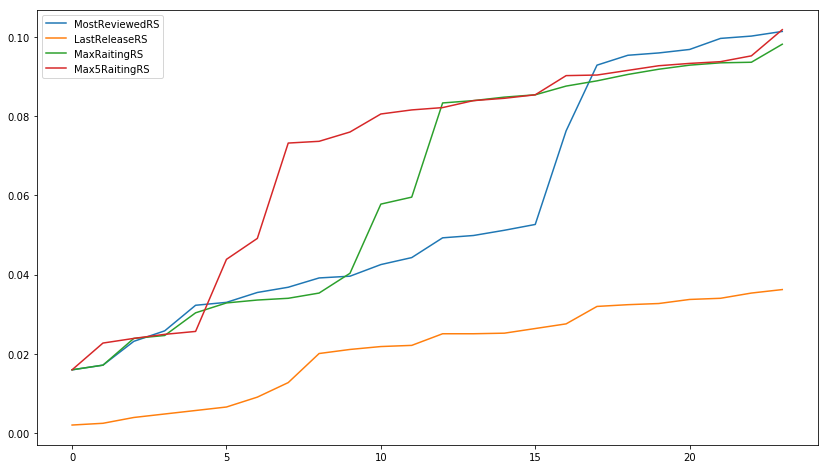

In [47]:
#  постоим график зависимости кол-во фильмов в рекомендации от попадания
%matplotlib inline
g_rate=[]
g2_rate=[]
g3_rate=[]
r5_rate=[]
for i in range(1,25):
    rec_dict=aa.get_batch_recs(test_df.uid,i)
    g_rate.append(hit_ratio(rec_dict,test_dict))
    rec_dict=bb.get_batch_recs(test_df.uid,i)
    g2_rate.append(hit_ratio(rec_dict,test_dict))
    rec_dict=cc.get_batch_recs(test_df.uid,i)
    g3_rate.append(hit_ratio(rec_dict,test_dict))
    rec_dict=r5.get_batch_recs(test_df.uid,i)
    r5_rate.append(hit_ratio(rec_dict,test_dict))
    
plt.figure(figsize=(14, 8))  
plt.plot(g_rate, label='MostReviewedRS') 
plt.plot(g2_rate, label='LastReleaseRS') 
plt.plot(g3_rate, label='MaxRaitingRS') 
plt.plot(r5_rate, label='Max5RaitingRS') 
plt.legend()

## видно что из всех рассмотренных наилучшие неперсональные рекомендации дает метод который выводит суммарный рейтинг по играм за которые пользователи поставили 5*  0.076

Так же видно что при количестве рекомендаций больше 11-12 Maks5Raiting сравнивается с суммарным общим рейтингом MaxRaitind 

вытащим 10 новых игр, так как у нас нет даных по выпуску игр будем считать что по максимум iid имеющих максимальный рейтинг понедельно от самого последнего отзыва

In [48]:
from datetime import date, timedelta

def  data_conv( row ):
     return date.fromtimestamp(row["dt"])


training_df['iso_dt'] = training_df.apply( data_conv, axis = 1 )
training_df.head()

,uid,iid,review,rating,dt,iso_dt
0,0,0,Installing the game was a struggle (because of...,1.0,1341792000,2012-07-09
1,1,0,If you like rally cars get this game you will ...,4.0,1372550400,2013-06-30
3,3,0,"I got this version instead of the PS3 version,...",3.0,1315958400,2011-09-14
4,4,0,I had Dirt 2 on Xbox 360 and it was an okay ga...,4.0,1308009600,2011-06-14
5,5,0,"Overall this is a well done racing game, with ...",4.0,1368230400,2013-05-11


In [49]:
n_dt=date.fromtimestamp(1375660800).isocalendar()
n_dt
training_df.dt.max()

1377129600

дата последнего отзыва из тренировочной выборки

In [50]:
#training_df[(training_df['iso_dt']<=st_date)].groupby(['iid'])['rating'].sum().sort_values(ascending=False) 
class MaxNewRaitingRS(NonPersRecommender):
    def __init__(self, df, awer):
        super(NonPersRecommender, self).__init__()
        self.recs = self._prepare_recs(df)
  
    def _prepare_recs(self, df):
        # считаем количество отзывов для каждого объекта (pandas сортирует их по убыванию)
        return df[(df['iso_dt']<=st_date)].groupby(['iid'])['rating'].sum().sort_values(ascending=False)  

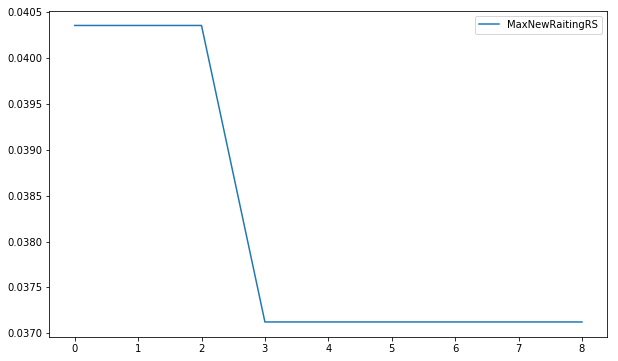

In [51]:
t_week=[]
week1 = timedelta(days=7)
st_date=date.fromtimestamp(1377129600)
for t_w in range(1,10):
    st_date=st_date-week1
    hh=MaxNewRaitingRS(training_df,st_date)
    rec_dict=hh.get_batch_recs(test_df.uid,10) 
    t_week.append(hit_ratio(rec_dict,test_dict))

    
plt.figure(figsize=(10, 6))  
plt.plot(t_week, label='MaxNewRaitingRS') 
plt.legend()



In [223]:
# нормально обсуждают 2 недели потом интерес падает
t_week

[0.04035216434336023,
 0.04035216434336023,
 0.04035216434336023,
 0.037123991195891416,
 0.037123991195891416,
 0.037123991195891416,
 0.037123991195891416,
 0.037123991195891416,
 0.037123991195891416]

### обсуждение игры идет 2 недели потом интерес падает, это рекомендации по последним вышедшим и сумме рейтинга

## Лучший результат по неперсонализированным рекомендательным системам  0.076